In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from scipy import interp
from sklearn import preprocessing


In [2]:
# reading the data

dataset = pd.read_csv("diabetic_original.csv")

In [3]:
# Shape of the data

dataset.shape

(101766, 50)

In [4]:
# top 5 rows of the data

dataset.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# listing the columns of the dataset

dataset.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [6]:
# number of unique patients

dataset.patient_nbr.nunique()

71518

In order to eliminate bias in the analysis, we keep only the patients with the first admission

In [503]:
# eliminating duplicates based on the 'patient_nbr' - patient number column (unique identifier for a patient)

dataset.drop_duplicates(subset='patient_nbr', keep='first', inplace=True)

In [504]:
# dimensions of the dataset after the elimination of duplicate values

dataset.shape

(71518, 50)

Text(0, 0.5, 'Count')

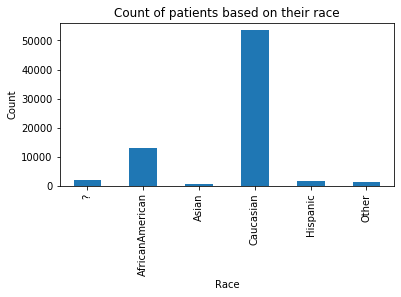

In [505]:
# count of patients grouped by race

ax = dataset.groupby(['race']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,3), 
                                                      title = 'Count of patients based on their race')
ax.set_xlabel('Race')
ax.set_ylabel('Count')

In [506]:
# count of patients belonging to different races 

dataset.groupby(['race']).count()['patient_nbr']

race
?                   1948
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               1178
Name: patient_nbr, dtype: int64

By looking at the above graph and summary statistics, we can see that there is a category "?" <br>
We can replace that with other.

In [507]:
# replacing the "?" in the column "race" with "other"

dataset['race'].replace({"?":"Other"}, inplace= True)

In [508]:
# new count of patients belonging to different races

dataset.groupby(['race']).count()['patient_nbr']

race
AfricanAmerican    12887
Asian                497
Caucasian          53491
Hispanic            1517
Other               3126
Name: patient_nbr, dtype: int64

In [509]:
%matplotlib inline 

Text(0, 0.5, 'Count')

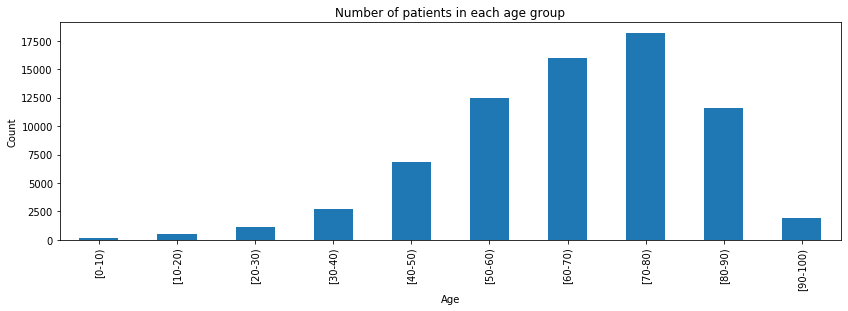

In [510]:
# number of patients in each age group

ax = dataset.groupby(['age']).count()['patient_nbr'].plot(kind='bar',
                                    figsize=(14,4),
                                    title="Number of patients in each age group")
ax.set_xlabel("Age")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

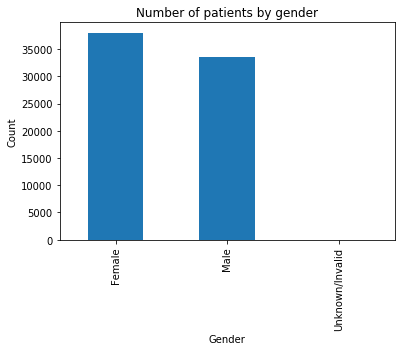

In [511]:
# count of patients grouped by gender

ax = dataset.groupby(['gender']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients by gender");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

From the above chart we can see that there is a category called "Unknown/Invalid" in the gender. We need to dwell more into the count of rows for different categorical values in the gender column and remove the "Unknown/Invalid" category from the data. 

In [512]:
# count of different categories in the 'gender' columns

dataset.groupby('gender').count()['patient_nbr']

gender
Female             38025
Male               33490
Unknown/Invalid        3
Name: patient_nbr, dtype: int64

In [513]:
# removing the "Unknown/Invalid" category from the 'gender' column since there are only 3 records

dataset.drop(dataset[dataset['gender'] == "Unknown/Invalid"].index, inplace=True)

In [514]:
# new dimensions of the dataset

dataset.shape

(71515, 50)

Text(17.200000000000003, 0.5, 'Count')

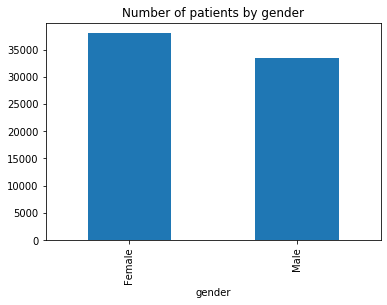

In [515]:
# # count of patients grouped by gender after removing the "Unknown/Invalid" rows

dataset.groupby(['gender']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients by gender");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

Text(17.200000000000003, 0.5, 'Count')

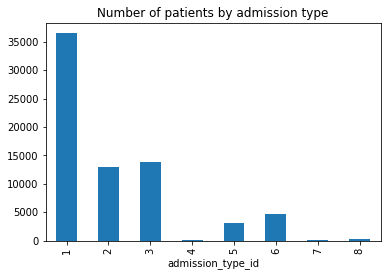

In [516]:
# count of patients grouped by based on admission type

dataset.groupby(['admission_type_id']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients by admission type");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

Text(17.200000000000003, 0.5, 'Count')

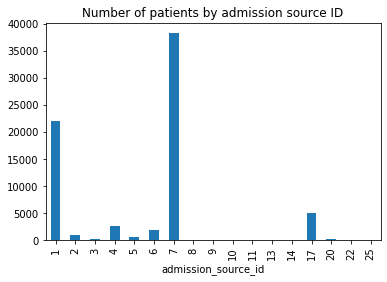

In [517]:
dataset.groupby(['admission_source_id']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients by admission source ID");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

Text(17.200000000000003, 0.5, 'Count')

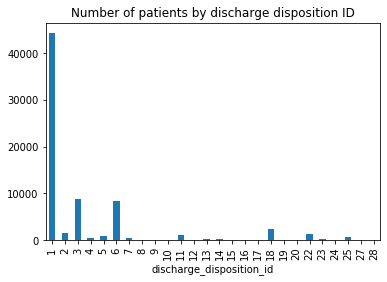

In [518]:
dataset.groupby(['discharge_disposition_id']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients by discharge disposition ID");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

Text(17.200000000000003, 0.5, 'Count')

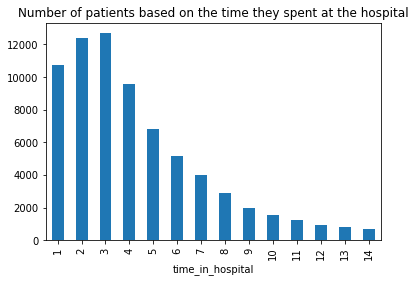

In [519]:
dataset.groupby(['time_in_hospital']).count()['patient_nbr'].plot(kind = 'bar', figsize = (6,4),
                                                             title = "Number of patients based on the time they spent at the hospital");
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

remove duplicate rows - retain only the first admission <br>
remove unnesesary columns <br>
do all those encodings <br>
standardize the diag 1,2,3 columns - before that find the summary statistics for those columns <br>
run base model <br>
talk about the different methods that can be used - forward, backward, hybrid selection - either in R or Python
Use Nick Sherman's code in R for XgBoost and CV chart

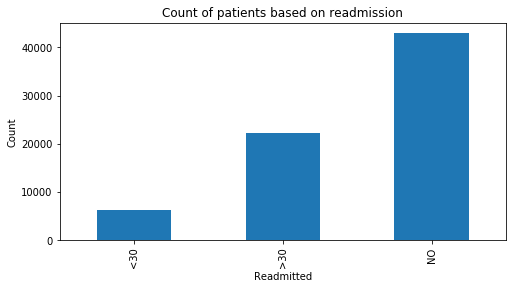

In [520]:
# count of patients grouped by based on re-admission

ax = dataset.groupby(['readmitted']).count()['patient_nbr'].plot(kind = 'bar', figsize = (8,4), 
                                                            title = "Count of patients based on readmission")
ax.set_xlabel("Readmitted")
ax.set_ylabel("Count");

In [521]:
dataset.groupby(['readmitted']).count()['patient_nbr']

readmitted
<30     6293
>30    22240
NO     42982
Name: patient_nbr, dtype: int64

In [522]:
dataset.groupby(['medical_specialty']).count()['patient_nbr']

medical_specialty
?                                   34475
AllergyandImmunology                    6
Anesthesiology                          7
Anesthesiology-Pediatric               13
Cardiology                           4265
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Surgery-Thoracic                       92
Surgery-Vascular                      362
SurgicalSpecialty                      26
Urology                               530
Name: patient_nbr, Length: 71, dtype: int64

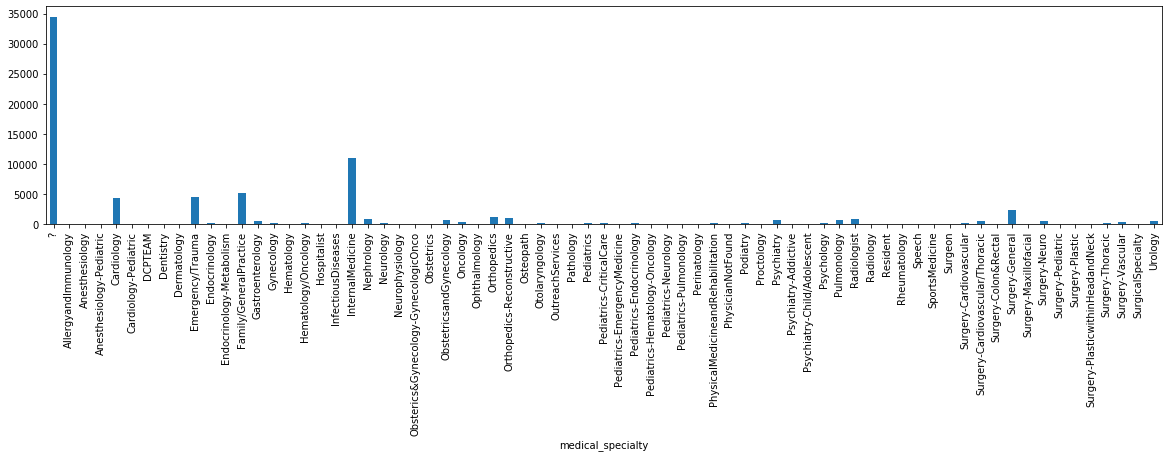

In [523]:
dataset.groupby(['medical_specialty']).count()['race'].plot(kind = 'bar', figsize = (20,4));

From the above chart, we can say that there are 34475 misssing values i.e. "?" in the dataset for the column "medical_specialty". Hence we need to remove this coulmn

In [524]:
# viewing the count of values for different weights

dataset.groupby(['weight']).count()['patient_nbr']

weight
>200             3
?            68662
[0-25)          46
[100-125)      566
[125-150)      131
[150-175)       33
[175-200)        9
[25-50)         89
[50-75)        781
[75-100)      1195
Name: patient_nbr, dtype: int64

From the above chart, we can say that there are 68662 misssing values i.e. "?" in the dataset for the column
"weight". Hence we need to remove this coulmn

In [525]:
dataset.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

Based on the above charts and exploratory data analysis, we now drop columns 
encounter_id, patient_nbr, weight, admission_type_id, discharge_disposition_id, admission_source_id, payer_code, number_outpatient, medical_specialty, number_emergency, number_inpatient

In [526]:
# dropping columns that are not required for our analysis

dataset.drop(columns= ['encounter_id', 'patient_nbr', 'weight', 'admission_type_id', 'discharge_disposition_id', 
                       'admission_source_id', 'payer_code', 'number_outpatient', 'medical_specialty', 'number_emergency',
                      'number_inpatient'], inplace= True)

In [527]:
dataset.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [528]:
dataset.shape

(71515, 39)

In [529]:
dataset.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),1,41,0,1,250.83,?,?,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),3,59,0,18,276,250.01,255,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),2,11,5,13,648,250,V27,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),2,44,1,16,8,250.43,403,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,51,0,8,197,157,250,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


The values in the diag_1, diag_2, diag_3 have garbage values such as "?" and values starting with "V". We need to remove them.

In [530]:
dataset = dataset[~dataset['diag_1'].str.startswith('?')]
dataset = dataset[~dataset['diag_1'].str.startswith('V')]
dataset = dataset[~dataset['diag_1'].str.startswith('E')]
dataset = dataset[~dataset['diag_2'].str.startswith('?')]
dataset = dataset[~dataset['diag_2'].str.startswith('V')]
dataset = dataset[~dataset['diag_2'].str.startswith('E')]
dataset = dataset[~dataset['diag_3'].str.startswith('?')]
dataset = dataset[~dataset['diag_3'].str.startswith('V')]
dataset = dataset[~dataset['diag_3'].str.startswith('E')]

In [531]:
dataset.shape

(64518, 39)

In [532]:
# datatypes of different columns in the data

dataset.dtypes

race                        object
gender                      object
age                         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide             

Since the tests that have been conducted are categorical columns with the values "Yes" and "No". We need to change the datatype to 'categorical'

In [533]:
# changing the datatype to 'categorical' for specific 'tests'

# converting the columns into categorical datatype

dataset["race"] = dataset["race"].astype('category')
dataset["gender"] = dataset["gender"].astype('category')
dataset["age"] = dataset["age"].astype('category')
dataset["max_glu_serum"] = dataset["max_glu_serum"].astype('category')
dataset["A1Cresult"] = dataset["A1Cresult"].astype('category')
dataset["metformin"] = dataset["metformin"].astype('category')
dataset["repaglinide"] = dataset["repaglinide"].astype('category')
dataset["nateglinide"] = dataset["nateglinide"].astype('category')
dataset["chlorpropamide"] = dataset["chlorpropamide"].astype('category')
dataset["glimepiride"] = dataset["glimepiride"].astype('category')
dataset["acetohexamide"] = dataset["acetohexamide"].astype('category')
dataset["glipizide"] = dataset["glipizide"].astype('category')
dataset["glyburide"] = dataset["glyburide"].astype('category')
dataset["tolbutamide"] = dataset["tolbutamide"].astype('category')
dataset["pioglitazone"] = dataset["pioglitazone"].astype('category')
dataset["rosiglitazone"] = dataset["rosiglitazone"].astype('category')
dataset["acarbose"] = dataset["acarbose"].astype('category')
dataset["miglitol"] = dataset["miglitol"].astype('category')
dataset["troglitazone"] = dataset["troglitazone"].astype('category')
dataset["examide"] = dataset["examide"].astype('category')
dataset["citoglipton"] = dataset["citoglipton"].astype('category')
dataset["insulin"] = dataset["insulin"].astype('category')
dataset["glyburide-metformin"] = dataset["glyburide-metformin"].astype('category')
dataset["glipizide-metformin"] = dataset["glipizide-metformin"].astype('category')
dataset["glimepiride-pioglitazone"] = dataset["glimepiride-pioglitazone"].astype('category')
dataset["metformin-rosiglitazone"] = dataset["metformin-rosiglitazone"].astype('category')
dataset["metformin-pioglitazone"] = dataset["metformin-pioglitazone"].astype('category')
dataset["change"] = dataset["change"].astype('category')
dataset["diabetesMed"] = dataset["diabetesMed"].astype('category')
dataset["readmitted"] = dataset["readmitted"].astype('category')
dataset["tolazamide"] = dataset["tolazamide"].astype('category')

In [534]:
# datatypes of different columns in the data after performing the above change

dataset.dtypes

race                        category
gender                      category
age                         category
time_in_hospital               int64
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
glipizide                   category
glyburide                   category
tolbutamide                 category
pioglitazone                category
rosiglitazone               category
acarbose                    category
miglitol                    category
troglitazone                category
t

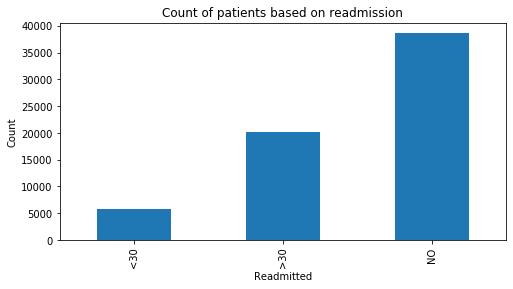

In [535]:
# count of patients grouped by based on re-admission

ax = dataset.groupby(['readmitted']).count()['race'].plot(kind = 'bar', figsize = (8,4), 
                                                            title = "Count of patients based on readmission")
ax.set_xlabel("Readmitted")
ax.set_ylabel("Count");

In [536]:
dataset.groupby(['readmitted']).count()['race']

readmitted
<30     5705
>30    20148
NO     38665
Name: race, dtype: int64

Now we will use the LabelEncoder and OneHotEncoder to fit and transform the categorical values present in the dataset.
For that we will split the dataset as 'categorical' data and 'non-categorical' data

In [537]:
# dataset_non_cat has only columns without the categorical datatypes

dataset_non_cat = dataset.select_dtypes(exclude=['category'])

dataset_non_cat.shape

(64518, 8)

In [538]:
# resetting the index of non-categorical data

dataset_non_cat = dataset_non_cat.reset_index()
dataset_non_cat = dataset_non_cat.drop(columns=['index'])

In [539]:
dataset_non_cat.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses
0,3,59,0,18,276,250.01,255,9
1,2,44,1,16,8,250.43,403,7
2,1,51,0,8,197,157,250,5
3,3,31,6,16,414,411,250,9
4,5,73,0,12,428,492,250,8


rough 

In [540]:
# perform feature scaling to normalize the diag_1,2,3 values

from sklearn import preprocessing

x = dataset_non_cat[['diag_1', 'diag_2','diag_3']].values
min_max_scaler = preprocessing.MinMaxScaler()
diag_scaled = min_max_scaler.fit_transform(x)
diag_scaled = pd.DataFrame(diag_scaled)
diag_scaled

,0,1,2
0,0.274096,0.246489,0.251509
1,0.005020,0.246911,0.400402
2,0.194779,0.152918,0.246479
3,0.412651,0.408451,0.246479
4,0.426707,0.489940,0.246479
...,...,...,...
64513,0.573293,0.572435,0.246499
64514,0.591365,0.597586,0.516097
64515,0.996988,0.583501,0.400402
64516,0.290161,0.003018,0.300805


In [541]:
# drop the old columns

dataset_non_cat = dataset_non_cat.drop(columns=['diag_1','diag_2','diag_3'], axis= 1)
dataset_non_cat

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
0,3,59,0,18,9
1,2,44,1,16,7
2,1,51,0,8,5
3,3,31,6,16,9
4,5,73,0,12,8
...,...,...,...,...,...
64513,9,50,2,33,9
64514,14,73,6,26,9
64515,2,46,6,17,9
64516,5,76,1,22,9


In [542]:
# add new 'normalized' columns

dataset_non_cat = pd.concat([dataset_non_cat, diag_scaled], axis = 1)

In [543]:
dataset_non_cat

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,0,1,2
0,3,59,0,18,9,0.274096,0.246489,0.251509
1,2,44,1,16,7,0.005020,0.246911,0.400402
2,1,51,0,8,5,0.194779,0.152918,0.246479
3,3,31,6,16,9,0.412651,0.408451,0.246479
4,5,73,0,12,8,0.426707,0.489940,0.246479
...,...,...,...,...,...,...,...,...
64513,9,50,2,33,9,0.573293,0.572435,0.246499
64514,14,73,6,26,9,0.591365,0.597586,0.516097
64515,2,46,6,17,9,0.996988,0.583501,0.400402
64516,5,76,1,22,9,0.290161,0.003018,0.300805


In [544]:
# dataset_cat has only columns with the categorical datatypes

dataset_cat = dataset.select_dtypes(include=["category"])
dataset_cat.shape

(64518, 31)

In [545]:
dataset_cat.head()

,race,gender,age,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),None,None,No,No,No,No,No,...,No,Up,No,No,No,No,No,Ch,Yes,>30
3,Caucasian,Male,[30-40),None,None,No,No,No,No,No,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),None,None,No,No,No,No,No,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[50-60),None,None,No,No,No,No,No,...,No,Steady,No,No,No,No,No,No,Yes,>30
7,Caucasian,Male,[70-80),None,None,No,No,No,No,No,...,No,No,No,No,No,No,No,No,Yes,>30


In [546]:
# resetting the index

dataset_cat = dataset_cat.reset_index()
dataset_cat = dataset_cat.drop(columns=['index'])

But since the last column is 'readmitted' - which should be used as the response variable, we are not using it in the label-encoding and one-hot encoding 

In [547]:
# the response variable

y = dataset_cat.iloc[:,30]

In [548]:
y

0        >30
1         NO
2         NO
3        >30
4        >30
        ... 
64513    >30
64514    >30
64515    >30
64516     NO
64517     NO
Name: readmitted, Length: 64518, dtype: category
Categories (3, object): [<30, >30, NO]

In [549]:
y.shape

(64518,)

In [550]:
dataset_cat = dataset_cat.iloc[:,:30]

In [551]:
# import preprocessing from sklearn
from sklearn import preprocessing

Now we will use the LabelEncoder and OneHotEncoder to fit and transform the categorical values present in dataset_cat dataframe

In [552]:
# TODO: create a LabelEncoder object and fit it to each feature in 'dataset_cat' dataframe


# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
dataset_cat_laben = dataset_cat.apply(le.fit_transform)
dataset_cat_laben.head()

# now dataset_cat_laben has the data in dataset_cat - but transformed using label encoder

,race,gender,age,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,2,0,1,2,2,1,1,1,1,1,...,0,0,3,1,0,0,0,0,0,1
1,2,1,3,2,2,1,1,1,1,1,...,0,0,3,1,0,0,0,0,0,1
2,2,1,4,2,2,1,1,1,1,1,...,0,0,2,1,0,0,0,0,0,1
3,2,1,5,2,2,1,1,1,1,1,...,0,0,2,1,0,0,0,0,1,1
4,2,1,7,2,2,1,1,1,1,1,...,0,0,1,1,0,0,0,0,1,1


In [553]:
# TODO: create a OneHotEncoder object, and fit it to all of dataset_cat_laben dataframe and then save the final 
# transformed values in the "onehotlabels" dataframe.

# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(dataset_cat_laben)

# 3. Transform
dataset_cat_onehotlabels = enc.transform(dataset_cat_laben).toarray()
dataset_cat_onehotlabels.shape



# as you can see, you've the same number of rows 
# but now you've so many more columns due to how we changed all the categorical data into numerical data

(64518, 97)

In [554]:
dataset_cat_onehotlabels

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]])

Since the 'dataset_cat_onehotlabels' - which is essentially our 'categorical' columns is a numpy array, we need to convert
it into a dataframe - and that would be our final encoded 'dataset_cat' dataframe

In [555]:
# now we make "dataset_cat_onehotlabels" into a dataframe 
# essentially "dataset_encoded" is our X with categorical columns

dataset_cat = pd.DataFrame(dataset_cat_onehotlabels)

In [556]:
dataset_cat.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [557]:
# we then join the "dataset_non_cat" (which has non-categorical data) with "dataset_cat" (which has categorical data)
# to make our final X dataframe i.e. predictors dataframe
# dataset_predictors is the "X"
    
dataset_predictors = pd.concat([dataset_cat, dataset_non_cat], axis= 1)

In [558]:
dataset_predictors.shape

(64518, 105)

In [559]:
dataset_predictors.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,0,1,2
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3,59,0,18,9,0.274096,0.246489,0.251509
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2,44,1,16,7,0.005020,0.246911,0.400402
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1,51,0,8,5,0.194779,0.152918,0.246479
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,3,31,6,16,9,0.412651,0.408451,0.246479
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,5,73,0,12,8,0.426707,0.489940,0.246479


In [560]:
# concatenating the categorical and non-categorical data i.e. the predictors onto the response variable i.e. 'y' - readmitted

dataset_final = pd.concat([dataset_predictors, y], axis=1)

In [561]:
dataset_final.shape

(64518, 106)

In [437]:
dataset_final.head()

,0,1,2,3,4,5,6,7,8,9,...,96,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,0,1,2,readmitted
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,3,59,0,18,9,0.274096,0.246489,0.251509,>30
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,2,44,1,16,7,0.005020,0.246911,0.400402,NO
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1,51,0,8,5,0.194779,0.152918,0.246479,NO
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3,31,6,16,9,0.412651,0.408451,0.246479,>30
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,5,73,0,12,8,0.426707,0.489940,0.246479,>30


In [438]:
# X and y for the classification algorithms

X = dataset_final.iloc[:, :105].values
y = dataset_final.iloc[:, 105].values

In [439]:
X.shape

(64518, 105)

In [440]:
y.shape

(64518,)

In [441]:
type(y)

pandas.core.arrays.categorical.Categorical

Since y is not a 'pandas.core.arrays.categorical.Categorical', we need to change it to numpy.ndarry in order to
binarize the response variable for drawing ROC curve

In [442]:
y = np.array(y).ravel()

In [443]:
type(y)

numpy.ndarray

In [444]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# Binarize the output in order to be able to vizualize the model accuracy in the ROC curve
class_label = np.arange(0,3)
y = label_binarize(y, classes=class_label)
n_classes = y.shape[1]

In [445]:
y

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [446]:
y.shape

(64518, 3)

Now we are making the training and testing sets for our algorithm

In [447]:

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=234)

In [448]:
X_train

array([[0.        , 0.        , 1.        , ..., 0.4126506 , 0.43158954,
        0.41046278],
       [0.        , 0.        , 1.        , ..., 0.19477912, 0.19416499,
        0.17002012],
       [0.        , 0.        , 1.        , ..., 0.43273092, 0.26861167,
        0.32997988],
       ...,
       [0.        , 0.        , 1.        , ..., 0.71485944, 0.77967807,
        0.33702213],
       [0.        , 0.        , 0.        , ..., 0.48493976, 0.19315895,
        0.19315895],
       [1.        , 0.        , 0.        , ..., 0.78614458, 0.42253521,
        0.78169014]])

In [449]:
X_test

array([[0.        , 0.        , 1.        , ..., 0.53012048, 0.27665996,
        0.24647887],
       [0.        , 0.        , 1.        , ..., 0.25100402, 0.39839034,
        0.24044266],
       [0.        , 0.        , 1.        , ..., 0.27811245, 0.57645875,
        0.24648893],
       ...,
       [0.        , 0.        , 1.        , ..., 0.43373494, 0.49094567,
        0.42152918],
       [0.        , 0.        , 0.        , ..., 0.57630522, 0.28370221,
        0.78873239],
       [0.        , 0.        , 1.        , ..., 0.27309237, 0.51408451,
        0.40744467]])

In [450]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

In [451]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

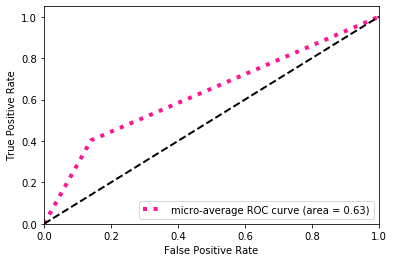

In [452]:
# KNN classifier

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show()

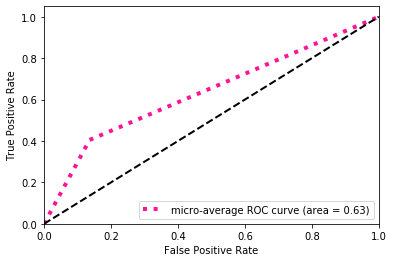

In [453]:
# Random Forest


# # Fitting Random Forest Classification to the Training set with 10 trees

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)

# # Fitting Random Forest Classification to the Training set with 500 trees

# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
y_pred = classifier.predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show() 



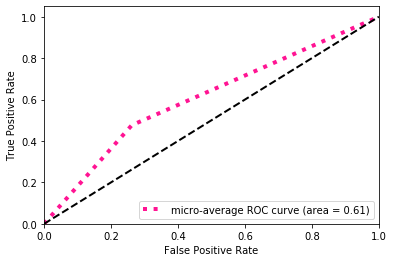

In [454]:
# Decision Tree


# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show() 



In [369]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [370]:
from keras.layers import Activation, Dense

In [455]:
# define the keras model
model = Sequential()
model.add(Dense(36, input_dim=105, activation='tanh'))
model.add(Dense(24, activation='tanh'))
model.add(Dense(12, activation='tanh'))
# model.add(Dense(6, activation='tanh'))
model.add(Dense(3, activation='tanh'))
model.add(Activation('softmax'))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
51614/51614 [==============================] - 5s 91us/step - loss: 0.8853 - acc: 0.5993
Epoch 2/10
51614/51614 [==============================] - 4s 84us/step - loss: 0.8834 - acc: 0.6000
Epoch 3/10
51614/51614 [==============================] - 5s 92us/step - loss: 0.8830 - acc: 0.6000
Epoch 4/10
51614/51614 [==============================] - 4s 83us/step - loss: 0.8823 - acc: 0.6001
Epoch 5/10
51614/51614 [==============================] - 4s 86us/step - loss: 0.8818 - acc: 0.6000
Epoch 6/10
51614/51614 [==============================] - 4s 86us/step - loss: 0.8810 - acc: 0.6000
Epoch 7/10
51614/51614 [==============================] - 4s 86us/step - loss: 0.8804 - acc: 0.5999
Epoch 8/10
51614/51614 [==============================] - 5s 100us/step - loss: 0.8799 - acc: 0.6001
Epoch 9/10
51614/51614 [==============================] - 5s 99us/step - loss: 0.8797 - acc: 0.6001
Epoch 10/10
12904/12904 [==============================] - 0s 20us/step
Accuracy: 59.66


In [377]:
dataset_final_l30 = dataset_final[dataset_final["readmitted"] == '<30']
dataset_final_l30 = dataset_final_l30.sample(n=5000)
dataset_final_l30 = dataset_final_l30.reset_index()
dataset_final_l30 = dataset_final_l30.drop(columns=['index'])
dataset_final_l30.head()

,0,1,2,3,4,5,6,7,8,9,...,96,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,readmitted
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1,23,2,11,780,276,414,9,<30
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,5,55,0,8,411,575,599,7,<30
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,8,64,0,15,398,394,397,9,<30
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,5,57,5,19,414,411,403,9,<30
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,3,2,0,12,808,276,427,9,<30


In [378]:
dataset_final_m30 = dataset_final[dataset_final["readmitted"] == '>30']
dataset_final_m30 = dataset_final_m30.sample(n=5000)
dataset_final_m30 = dataset_final_m30.reset_index()
dataset_final_m30 = dataset_final_m30.drop(columns=['index'])
dataset_final_m30.head()

,0,1,2,3,4,5,6,7,8,9,...,96,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,readmitted
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,6,37,0,13,427,162,197,9,>30
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,4,57,0,5,560,555,250,4,>30
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,8,60,5,38,414,413,280,9,>30
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,3,49,0,10,576,70,70,9,>30
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,4,83,2,18,531,285,250.01,5,>30


In [379]:
dataset_final_no = dataset_final[dataset_final["readmitted"] == 'NO']
dataset_final_no = dataset_final_no.sample(n=5000)
dataset_final_no = dataset_final_no.reset_index()
dataset_final_no = dataset_final_no.drop(columns=['index'])
dataset_final_no.head()

,0,1,2,3,4,5,6,7,8,9,...,96,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,readmitted
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,2,64,2,16,592,591,250.02,5,NO
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,11,72,2,38,821,413,428,9,NO
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1,34,6,12,414,413,250,7,NO
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,8,58,1,34,574,997,518,9,NO
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,1,3,12,996,585,403,9,NO


In [380]:
# concatenating the sliced (i.e. 5000 rows) dataframe and joining to form the new dataframe

dataset_final = pd.concat([dataset_final_no, dataset_final_l30, dataset_final_m30], axis=0)

In [381]:
dataset_final.shape

(15000, 106)

In [382]:
# X and y for the classification algorithms

X = dataset_final.iloc[:, :105].values
y = dataset_final.iloc[:, 105].values

In [383]:
X.shape

(15000, 105)

In [384]:
y.shape

(15000,)

In [385]:
type(y)

pandas.core.arrays.categorical.Categorical

Since y is not a 'pandas.core.arrays.categorical.Categorical', we need to change it to numpy.ndarry in order to
binarize the response variable for drawing ROC curve

In [386]:
y = np.array(y).ravel()

In [387]:
type(y)

numpy.ndarray

In [388]:
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

# Binarize the output in order to be able to vizualize the model accuracy in the ROC curve
class_label = np.arange(0,3)
y = label_binarize(y, classes=class_label)
n_classes = y.shape[1]

In [389]:
y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [390]:
y.shape

(15000, 3)

Now we are making the training and testing sets for our algorithm

In [391]:

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=234)

In [392]:
X_train

array([[0.0, 0.0, 1.0, ..., '428', '427', 9],
       [0.0, 0.0, 1.0, ..., '276', '401', 9],
       [0.0, 0.0, 1.0, ..., '491', '428', 7],
       ...,
       [0.0, 0.0, 1.0, ..., '428', '403', 9],
       [0.0, 0.0, 1.0, ..., '414', '782', 9],
       [0.0, 0.0, 1.0, ..., '331', '414', 8]], dtype=object)

In [393]:
X_test

array([[1.0, 0.0, 0.0, ..., '424', '250', 9],
       [0.0, 0.0, 1.0, ..., '682', '276', 9],
       [0.0, 0.0, 1.0, ..., '250', '401', 3],
       ...,
       [0.0, 0.0, 1.0, ..., '250', '427', 9],
       [1.0, 0.0, 0.0, ..., '276', '707', 9],
       [1.0, 0.0, 0.0, ..., '428', '253', 9]], dtype=object)

In [394]:
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [395]:
y_test

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

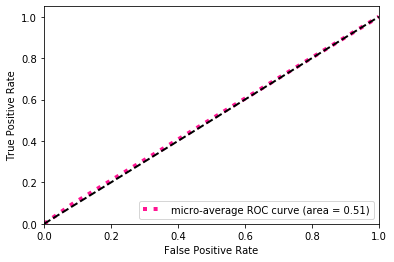

In [396]:
# KNN classifier

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show()

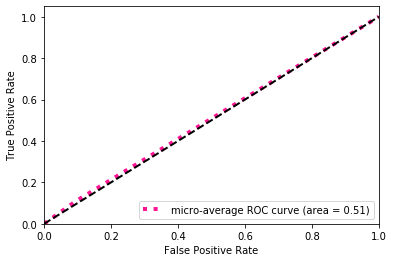

In [397]:
# Random Forest


# # Fitting Random Forest Classification to the Training set with 10 trees

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)

# # Fitting Random Forest Classification to the Training set with 500 trees

# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
y_pred = classifier.predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show() 



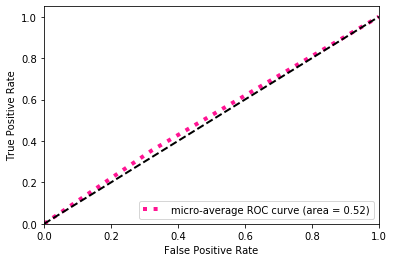

In [398]:
# Decision Tree


# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plotting micro-average ROC curve for the multiclass problem

# Compute micro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot the ROC curve

# I am calculating Micro Average because the classes are not equally distributed

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# I am not calculating Macro Average because the classes are not equally distributed

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC for Random Forest with 10 trees')
#plt.title('ROC for Random Forest with 500 trees')
plt.legend(loc="lower right")
plt.show() 



In [399]:
# define the keras model
model = Sequential()
model.add(Dense(36, input_dim=105, activation='tanh'))
model.add(Dense(24, activation='tanh'))
model.add(Dense(12, activation='tanh'))
# model.add(Dense(6, activation='tanh'))
model.add(Dense(3, activation='tanh'))
model.add(Activation('softmax'))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
12000/12000 [==============================] - 2s 151us/step - loss: 1.1031 - acc: 0.3328
Epoch 2/10
12000/12000 [==============================] - 2s 167us/step - loss: 1.0994 - acc: 0.3320
Epoch 3/10
12000/12000 [==============================] - 2s 161us/step - loss: 1.0992 - acc: 0.3326
Epoch 4/10
12000/12000 [==============================] - 2s 145us/step - loss: 1.0988 - acc: 0.3323
Epoch 5/10
12000/12000 [==============================] - 1s 98us/step - loss: 1.0988 - acc: 0.3325
Epoch 6/10
12000/12000 [==============================] - 1s 96us/step - loss: 1.0986 - acc: 0.3352
Epoch 7/10
12000/12000 [==============================] - 1s 100us/step - loss: 1.0987 - acc: 0.3291
Epoch 8/10
12000/12000 [==============================] - 1s 96us/step - loss: 1.0986 - acc: 0.3280
Epoch 9/10
12000/12000 [==============================] - 1s 97us/step - loss: 1.0984 - acc: 0.3411
Epoch 10/10
3000/3000 [==============================] - 0s 60us/step
Accuracy: 34.50
